## Homework

> Note: sometimes your answer doesn't match one of the options exactly. That's fine. 
Select the option that's closest to your solution.

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score

from tqdm.auto import tqdm

## Dataset

In this homework, we will use Credit Card Data from book "Econometric Analysis".

Here's a wget-able [link](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv):

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
```
The goal of this homework is to inspect the output of different evaluation metrics by creating a classification model (target column `card`). 

In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv

--2022-10-02 19:45:54--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73250 (72K) [text/plain]
Saving to: ‘AER_credit_card_data.csv’

AER_credit_card_dat 100%[===================>]  71.53K  --.-KB/s    in 0.01s   

2022-10-02 19:45:54 (5.63 MB/s) - ‘AER_credit_card_data.csv’ saved [73250/73250]



## Preparation

* Create the target variable by mapping `yes` to 1 and `no` to 0. 
* Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`.

In [18]:
cc_df = pd.read_csv('AER_credit_card_data.csv')
cc_df['target'] = np.where(cc_df.card == 'yes', 1, 0)
cc_df.sample(5, random_state=10)

full_train, test = train_test_split(cc_df, test_size=0.2, random_state=1)
train, val = train_test_split(full_train, test_size=0.25, random_state=1)

# check sizes
list(map(lambda df: df.shape, [train, val, test]))

[(791, 13), (264, 13), (264, 13)]

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `card` variable.
* Use the training dataset for that.

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenditure']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `reports`
- `dependents`
- `active`
- `share`

In [70]:
train_numeric = train.select_dtypes([np.number])

def get_auc(tar, col):
    fpr, tpr, thresholds = roc_curve(tar, col)
    temp_auc = auc(fpr, tpr)
    
    if temp_auc > 0.5:
        return temp_auc
    else:
        fpr, tpr, thresholds = roc_curve(tar, -1*col)
        return auc(fpr, tpr)

numeric_aucs = train_numeric.drop('target', axis=1).apply(lambda c: get_auc(train_numeric.target, c))
numeric_aucs_df = pd.DataFrame(numeric_aucs, columns=['auc'])

options = ['reports', 'dependents', 'active', 'share']

numeric_aucs_df.loc[options].sort_values('auc', ascending=False)

,auc
share,0.989184
reports,0.716663
active,0.604317
dependents,0.532776


## Training the model

From now on, use these columns only:

```
["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [88]:
FIELDS = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
DV = DictVectorizer(sparse=False)
DV.fit(cc_df[FIELDS].to_dict(orient='records'))

def get_x(df):    
    df_dict = df[FIELDS].to_dict(orient='records')
    return DV.transform(df_dict)
  
train_y = train.target
val_y = val.target
test_y = test.target

train_x = get_x(train)
val_x = get_x(val)
test_x = get_x(test)

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.615
- 0.515
- 0.715
- 0.995

In [139]:
# sorry forgot roc_auc_score exists
mdl = LogisticRegression(solver='liblinear', random_state=1)
mdl.fit(train_x, train_y)

val_preds = mdl.predict_proba(val_x)[:, 1]

val_fpr, val_tpr, val_thresholds = roc_curve(val_y, val_preds)
val_auc = auc(val_fpr, val_tpr)

print(round(val_auc, 3))

0.995


## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on the validation dataset on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them


At which threshold precision and recall curves intersect?

* 0.1
* 0.3
* 0.6
* 0.8

,threshold,precision,recall
10,0.1,0.925110,0.995261
30,0.3,0.976190,0.971564
60,0.6,0.995122,0.966825
80,0.8,0.995122,0.966825


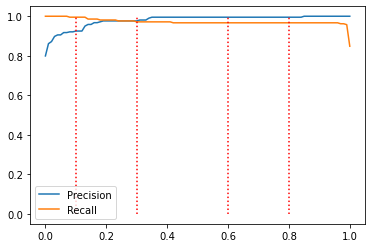

In [124]:
pr = pd.DataFrame({'threshold': np.arange(0.0, 1.01, 0.01)})

def get_precision(tar, preds, t):
    actual_pos = tar == 1
    pred_pos = preds >= t
    
    tp = (pred_pos & actual_pos).sum()
    fp = (pred_pos & ~actual_pos).sum()
    tn = (~pred_pos & ~actual_pos).sum()
    fn = (~pred_pos & actual_pos).sum()
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
        
    return (precision, recall)

pr[['precision', 'recall']] = pr.threshold.apply(lambda t: get_precision(val_y, val_preds, t)).apply(pd.Series)

options = [0.1, 0.3, 0.6, 0.8]

plt.plot(pr.threshold, pr.precision, label='Precision')
plt.plot(pr.threshold, pr.recall, label='Recall')
plt.vlines(options, 0, 1, colors='red', linestyles='dotted')
plt.legend()

pr[pr.threshold.isin(options)]

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing $F_1$:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01 using the validation set

At which threshold F1 is maximal?

- 0.1
- 0.4
- 0.6
- 0.7

In [126]:
def get_f_one(p, r):
    return 2 * (p * r) * (1 / (p + r))

pr['f_one'] = get_f_one(pr.precision, pr.recall)
pr.sort_values(['f_one'], ascending=False).head(5)

,threshold,precision,recall,f_one
39,0.39,0.995146,0.971564,0.983213
38,0.38,0.995146,0.971564,0.983213
37,0.37,0.995146,0.971564,0.983213
36,0.36,0.995146,0.971564,0.983213
35,0.35,0.995146,0.971564,0.983213


## Question 5

Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


How large is standard devidation of the AUC scores across different folds?

- 0.003
- 0.014
- 0.09
- 0.24

In [133]:
# recall we have DV trained already and have defined x_train

def train(y_train, df_train, C=1.0):
    x_train = get_x(df_train)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(x_train, y_train)
    
    return model

def predict(df, mdl):
    X = get_x(df)
    y_pred = mdl.predict_proba(X)[:, 1]

    return y_pred

In [141]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(full_train):
    df_train = full_train.iloc[train_idx]
    df_val = full_train.iloc[val_idx]

    y_train = df_train.target
    y_val = df_val.target

    model = train(y_train, df_train)
    y_pred = predict(df_val, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

round(np.std(scores), 3)

0.003

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

In [144]:
n_splits = 5

c_records = []

for C in tqdm([0.01, 0.1, 1, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    
    scores = []
    
    for train_idx, val_idx in kfold.split(full_train):
        df_train = full_train.iloc[train_idx]
        df_val = full_train.iloc[val_idx]

        y_train = df_train.target
        y_val = df_val.target

        model = train(y_train, df_train, C=C)
        y_pred = predict(df_val, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    
    dat = {
        'C': C,
        'score_mean': np.mean(scores),
        'score_std': np.std(scores)
    }
    
    c_records.append(dat)
    
c_df = pd.DataFrame.from_records(c_records)

c_df.sort_values(['score_std', 'C'], ascending=True)
    

  0%|          | 0/4 [00:00<?, ?it/s]

,C,score_mean,score_std
3,10.00,0.996638,0.002648
1,0.10,0.996541,0.002727
2,1.00,0.996472,0.002785
0,0.01,0.995457,0.003732


## Submit the results

* Submit your results here: https://forms.gle/8TfKNRd5Jq7sGK5M9
* You can submit your solution multiple times. In this case, only the last submission will be used 
* If your answer doesn't match options exactly, select the closest one

## Deadline

The deadline for submitting is October 3 (Monday), 23:00 CEST.

After that, the form will be closed.